1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [97]:
# houseprices.info()
houseprices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1379.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,567.240,1057.429,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,6.518,0.613,1978.506,1.767,472.980,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,1.625,0.645,24.690,0.747,213.805,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1900.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,795.750,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1961.000,1.000,334.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,477.500,991.500,1087.000,0.000,0.000,1464.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1980.000,2.000,480.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,808.000,1298.250,1391.250,728.000,0.000,1776.750,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,6110.000,4692.000,2065.000,572.000,5642.000,3.000,2.000,3.000,2.000,8.000,3.000,14.000,3.000,2010.000,4.000,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

_Missing Values_

We have 1,460 datapoints and eighty-one columns for seventy-nine variables. Many of the columns are not missing any values, thirteen columns are missing fewer than one hundred values, one column is missing approximately have its values, and the rest are missing at least 80% of values. 

I will drop 'alley', 'poolqc', 'fence', and 'miscfeature', all of which are missing values at least 80% of the cells.

Eight of the columns with missing values hold information on either the basement or the garage. These sets are missing the same amount of data, so my instinct is that the houses missing the data simply did not have basements or garage - therefore, I'll replace the missing values with None to create a new category.

I'll use interpolation on lotfrontage as this column has float values and is missing less than 10% of the data. This variable has fairly strong correlations with firstflrsf and lotarea, so I'm going to sort the data by these two columns and then interpolate lotfrontage.

I haven't yet decided how to handle the missing values in garageyrblt. It would be a pain to create a new category (None) for rows missing values because this would make the variable categorical instead of continuous.

According to the correlation matrix, there is a very strong correlation between garageyrblt and yearbuilt, so I'm going to fill all missing values in garageyrblt with those in yearbuilt, as I think this is the best way to fill all values and keep the integrity of the data. This increased the correlation between saleprices and garageyrblt by 0.022 - it would be prudent to keep this in mind during our analysis.

In [98]:
houseprices = houseprices.drop(['alley', 'poolqc', 'fence', 'miscfeature'], axis=1)

In [99]:
# Handling missing values
houseprices['masvnrtype'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtqual'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtcond'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtexposure'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtfintype1'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['bsmtfintype2'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagetype'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagefinish'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagequal'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['garagecond'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['fireplacequ'].fillna('None', inplace=True) # filling NaN values with 'None'
houseprices['electrical'].fillna('SBrkr', inplace=True) # filling NaN values with 'SBrkr'
houseprices['garageyrblt'].fillna(houseprices['yearbuilt'], inplace=True) # filling NaN values with 'SBrkr'
houseprices['masvnrarea'].fillna(0.00, inplace=True) # filling NaN values with 'SBrkr'


In [100]:
# houseprices.info()
houseprices.corr()

# print(houseprices.loc[houseprices['masvnrarea'].isnull().sum() > 0])
# null_columns=houseprices.columns[housepries.isnull().any()]
# houseprices[houseprices["masvnrarea"].isnull()][null_columns]
houseprices[houseprices['masvnrtype'] == 'None']

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
1,2,20,RL,80.000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
3,4,70,RL,60.000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,6,50,RL,85.000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
8,9,50,RM,51.000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.000,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,1,2008,WD,Normal,118000
10,11,20,RL,70.000,11200,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Hip,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,906,Unf,0,134,1040,GasA,Ex,Y,SBrkr,1040,0,0,1040,1,0,1,0,3,1,TA,5,Typ,0,None,Detchd,1965.000,Unf,1,384,TA,TA,Y,0,0,0,0,0,0,0,2,2008,WD,Normal,129500
12,13,20,RL,nan,12968,Pave,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.000,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.000,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,0,9,2008,WD,Normal,144000
15,16,45,RM,51.000,6120,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,7,8,1929,2001,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,832,832,GasA,Ex,Y,FuseA,854,0,0,854,0,0,1,0,2,1,TA,5,Typ,0,None,Detchd,1991.000,Unf,2,576,TA,TA,Y,48,112,0,0,0,0,0,7,2007,WD,Normal,132000
17,18,90,RL,72.000,10791,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1296,0,0,1296,0,0,2,0,2,2,TA,6,Typ,0,None,CarPort,1967.000,Unf,2,516,TA,TA,Y,0,0,0,0,0,0,500,10,2006,WD,Normal,90000
18,19,20,RL,66.000,13695,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,RRAe,Norm,1Fam,1Story,5,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,TA,TA,No,GLQ,646,Unf,0,468,1114,GasA,Ex,Y,SBrkr,1114,0,0,1114,1,0,1,1,3,1,Gd,6,Typ,0,None,Detchd,2004.000,Unf,2,576,TA,TA,Y,0,102,0,0,0,0,0,6,2008,WD,Normal,159000


In [101]:
houseprices.sort_values(['firstflrsf', 'lotarea'], ascending=[True, True])
# houseprices["lotfrontage"].fillna(houseprices["lotfrontage"].mean(), inplace=True)
houseprices['lotfrontage'] = houseprices.lotfrontage.interpolate(method ='linear', limit_direction ='forward')
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1460 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non

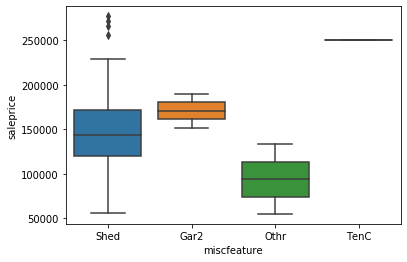

In [4]:
sns.boxplot(x='miscfeature', y='saleprice', data=houseprices)